# Dominik Sawicki 145402, Sebastian Szczepaniak 145280
## Grupa 7.1

# Zadanie 1 (na 3.0)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from matplotlib import colors

In [5]:
#konwerter: nie trzeba implementować samemu, można wykorzystać funkcję z bilbioteki
def hsv2rgb(h, s, v):
    return colors.hsv_to_rgb(np.array([h, s, v]))

# poniżej znajdują się funkcje modelujące kolejne gradienty z zadania.
# v to pozycja na osi ox: v jest od 0 do 1. Zewnetrzna funkcja wywołuje te metody podając
# różne v i oczekując trójki RGB bądź HSV reprezentującej kolor. Np. (0,0,0) w RGB to kolor czarny. 
# Należy uwikłać v w funkcję modelującą kolor. W tym celu dla kolejnych gradientów trzeba przyjąć 
# sobie jakieś punkty charakterystyczne,
# np. widzimy, że po lewej stronie (dla v = 0) powinien być kolor zielony a w środku niebieski (dla v = 0.5),
# a wszystkie punkty pomiędzy należy interpolować liniowo (proporcjonalnie). 

def gradient_rgb_bw(v):
    return (v, v, v)


def gradient_rgb_gbr(v):
    # (0, 1, 0) -> (0, 0, 1) -> (1, 0, 0)
    red = 0
    green = 0
    blue = 0
    if v < 0.5:
        green = 1-2*v
        blue = 2*v
    else:
        blue = 2*(1-v)
        red = 2*(v-0.5)
    return (red, green, blue)


def gradient_rgb_gbr_full(v):
    # (0, 1, 0) -> (0, 1, 1) -> (0, 0, 1) -> (1, 0, 1) -> (1, 0, 0)
    red = 0
    green = 0
    blue = 0
    if v < 0.25:
        green = 1
        blue = 4*v
    elif v < 0.5:
        blue = 1
        green = 1-4*(v-0.25)
    elif v < 0.75:
        blue = 1
        red = 4*(v-0.5)
    else:
        red = 1
        blue = 1 - 4*(v-0.75)
    
    return (red, green, blue)


def gradient_rgb_wb_custom(v):
    # (1, 1, 1) -> (1, 0, 1) -> (0, 0, 1) -> (0, 1, 1) -> (0, 1, 0) -> (1, 1, 0) -> (1, 0, 0) -> (0, 0, 0)
    # co 0.15
    red, green, blue = 0, 0, 0
    if v < 0.15:
        red = 1
        blue = 1
        green = 1 - (100/15)*v
    elif v < 0.3:
        red = 1 - (100/15)*(v-0.15)
        blue = 1
    elif v < 0.45:
        green = (100/15)*(v-0.3)
        blue = 1
    elif v < 0.6:
        green = 1
        blue = 1 - (100/15)*(v-0.45)
    elif v < 0.75:
        green = 1
        red = (100/15)*(v-0.6)
    elif v < 0.9:
        red = 1
        green = 1 - (100/15)*(v-0.75)
    else:
        red = 1 - (100/15)*(v-0.9)
    return (red, green, blue)


def gradient_hsv_bw(v):
    return hsv2rgb(0, 0, v)


def gradient_hsv_gbr(v):
    h = 120 + v*240
    s = 1
    V = 1
    return hsv2rgb(h/360, s, V)

def gradient_hsv_unknown(v):
    h = 120 - 120*v
    s = 0.5
    V = 1
    return hsv2rgb(h/360, s, V)


def gradient_hsv_custom(v):
    # (0, 1, 1) -> (60, 1, 1) -> (120, 1, 1) ->
    h = 360*v
    s = 1 - v
    V = 1
    return hsv2rgb(h/360, s, V)

In [6]:
def plot_color_gradients(gradients, names):
    # For pretty latex fonts (commented out, because it does not work on some machines)
    #rc('text', usetex=True) 
    #rc('font', family='serif', serif=['Times'], size=10)
    rc('legend', fontsize=10)

    column_width_pt = 400         # Show in latex using \the\linewidth
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch

    fig, axes = plt.subplots(nrows=len(gradients), sharex=True, figsize=(size, 0.75 * size))
    fig.subplots_adjust(top=1.00, bottom=0.05, left=0.25, right=0.95)


    for ax, gradient, name in zip(axes, gradients, names):
        # Create image with two lines and draw gradient on it
        img = np.zeros((2, 1024, 3))
        for i, v in enumerate(np.linspace(0, 1, 1024)):
            img[:, i] = gradient(v)

        im = ax.imshow(img, aspect='auto')
        im.set_extent([0, 1, 0, 1])
        ax.yaxis.set_visible(False)

        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.25
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='left', fontsize=10)

    fig.savefig('my-gradients.pdf')

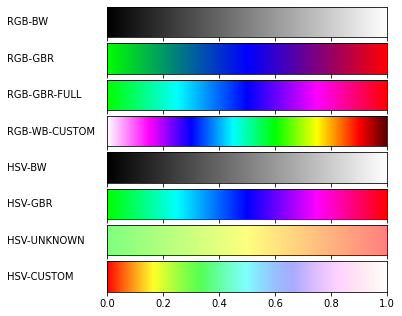

In [7]:
def toname(g):
    return g.__name__.replace('gradient_', '').replace('_', '-').upper()
    
gradients = (gradient_rgb_bw, gradient_rgb_gbr, gradient_rgb_gbr_full, gradient_rgb_wb_custom,
                 gradient_hsv_bw, gradient_hsv_gbr, gradient_hsv_unknown, gradient_hsv_custom)

plot_color_gradients(gradients, [toname(g) for g in gradients])

# Zadanie 2 (na 5.0)

In [8]:
file = open('big.dem', 'r')
lines = file.readlines()
file.close()
w, h, odl = map(int, lines[0].split())
data = []
for line in lines[1:]:
    data.append(line.split())
data = np.array(data, dtype='float')

In [9]:
highest_point = np.amax(data)  # this point will be red
lowest_point = np.amin(data)  # this point will be green

In [192]:
def gradient(point, edge_vector, factor):
    # max -> 0, min -> 120
    h = (highest_point - point)*120/(highest_point - lowest_point)  # making sure the lowest point gets (120, 1, 1) value and the highest (0, 1, 1)
    s = 1
    v = 1
    light_vector = [50, 10, 500]
    normalized_vectors = [edge_vector[0] / np.linalg.norm(edge_vector[0]),
                          edge_vector[1] / np.linalg.norm(edge_vector[1]),
                          light_vector / np.linalg.norm(light_vector)]
    dot_x = np.dot(normalized_vectors[0], normalized_vectors[2])
    dot_y = np.dot(normalized_vectors[1], normalized_vectors[2])
    angle_x = np.arccos(dot_x)
    angle_y = np.arccos(dot_y)
    edge_factor = 1/factor if factor > 0 else 1
    if angle_x > 0: v_x = 1 / angle_x
    else: v_x = 1
    if angle_y > 0: v_y = 1 / angle_y
    else: v_y = 1
    v = (v_x + v_y) / 2
    return hsv2rgb(h/360, s, v)

def depth_factor(data, x, y):
    area = []
    if x == 499 or y == 499:
        return 0
    area.append(abs(data[x+1, y]-data[x,y]))
    area.append(abs(data[x, y+1]-data[x,y]))
    return max(area)

def plot_map(data):
    img = np.zeros((w, h, 3))
    for x in range(w):
        for y in range(h):
            vector = []
            if x < 499:
                vector.append([x+1 - x, y-y, data[x+1, y] - data[x, y]])
            else:
                vector.append([x-1 - x, y-y, data[x-1, y] - data[x, y]])
            if y < 499:
                vector.append([x - x, y+1 - y, data[x, y+1] - data[x, y]])
            else:
                vector.append([x - x, y-1 - y, data[x, y-1] - data[x, y]])
            img[x, y] = gradient(data[x, y], vector, 1.5)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


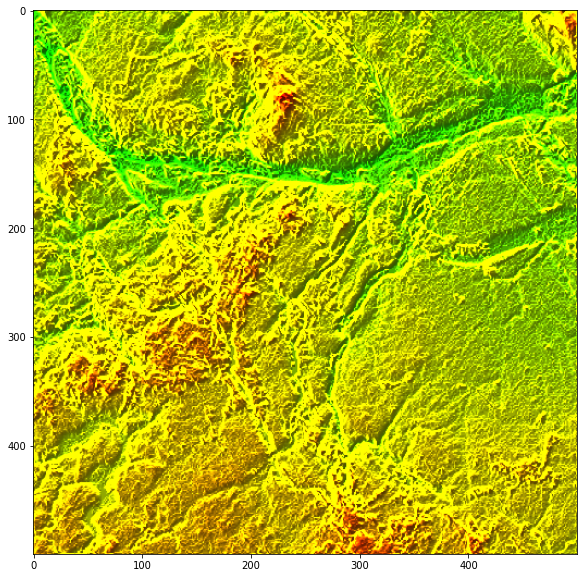

CPU times: user 29.9 s, sys: 39.8 ms, total: 29.9 s
Wall time: 30 s


In [193]:
%%time
plot_map(data)